# QuasiCopula vs TrajGWAS on Hapmap simulated data

Lets simulate data following TrajGWAS.jl model

$$y_{ij} = \mathbf{x}_{ij}^t\mathbf{\beta} + g_i\beta_g + \mathbf{z}_{ij}^t\mathbf{\gamma}_i + \epsilon_{ij}$$

+ $\beta$: fixed effects
+ $\gamma_i$: random effects (in model below, there is only a random intercept term here, i.e. z is vector of 1s)
+ $\epsilon$: a term that gives non constant variance

**Below, it seems that including $\gamma$ causes issues with QuasiCopula model, but including $\epsilon$ seems mostly okay**

In [13]:
# simulation script modified from: https://github.com/OpenMendel/TrajGWAS.jl/blob/main/data/sim_data.jl

using SnpArrays, WiSER, TrajGWAS, Random, QuasiCopula, Suppressor
using DataFrames, CSV, Statistics, Distributions, GLM, LinearAlgebra, StatsBase

datadir = normpath(joinpath(dirname(pathof(TrajGWAS)), "../data/"))
gen_file = joinpath(datadir * "hapmap3") # plink file without bed/bim/fam extensions
covfile = "trajgwas_plinkex.csv"
pvalpath = "trajGWAS_pval.csv"

# PLINK data 
hapmap = SnpArray(gen_file * ".bed")
famids = CSV.read(gen_file * ".fam", DataFrame, header=false)[!, 1]
hapmap = convert(Matrix{Float64}, hapmap, model=ADDITIVE_MODEL, impute=true)
toplist = sortperm(vec(var(hapmap, dims=1))[1:12000], rev=true)[1:30]

# simulation parameters
m, _ = size(hapmap)
ni = 10
Random.seed!(310)
sex = rand(0:1, m)
timeinvarX = [sex hapmap[:, 7828] hapmap[:, 8250] hapmap[:, 5] hapmap[:, 11793]] # time invariant covariates
p = 7
l = 7
q = 1

βtrue = [10.0; -3.2; 0.5; 0.5; 1.5; 0.25; 0.75]
τtrue = [0.2; -0.3; 0.5; -0.5; 0.5; 0.25; 0.15]
Σγ    = Matrix(Diagonal([2])) # does this mean γ ~ N(0, 2)? 
δγω   = [0.0]
σω    = [0.0]

Σγω   = [Σγ δγω; δγω' σω]
Lγω   = cholesky(Symmetric(Σγω), check = false).L
Lγ    = Lγω[1:q, 1:q]
lγω   = Lγω[q + 1, 1:q]
lω    = Lγω[q + 1, q + 1]

γω = Vector{Float64}(undef, q + 1)
z  = similar(γω) # hold vector of iid std normal

df = DataFrame()
obsvec = Vector{WSVarLmmObs{Float64}}(undef, m)
for i in 1:m
    sex_i = timeinvarX[i, 1]
    snp1_i = timeinvarX[i, 2]
    snp2_i = timeinvarX[i, 3]
    snp3_i = timeinvarX[i, 4]
    snp4_i = timeinvarX[i, 5]
    # Xu from a normal dist 0 mean 2 std 
    OnMeds = rand([0, 1], ni)
    # first column intercept, remaining entries iid std normal
    X = Matrix{Float64}(undef, ni, p)
    X[:, 1] .= 1
    X[:, 2] .= sex_i
    X[:, 3] = OnMeds
    X[:, 4] .= snp1_i
    X[:, 5] .= snp2_i
    X[:, 6] .= snp3_i
    X[:, 7] .= snp4_i

    # random intercept column
    Z = Matrix{Float64}(undef, ni, q)
    Z[:, 1] .= 1

    # first column intercept, remaining entries iid std normal
    W = Matrix{Float64}(undef, ni, l)
    W[:, 1] .= 1
    W[:, 2] .= sex_i
    W[:, 3] = OnMeds
    W[:, 4] .= snp1_i
    W[:, 5] .= snp2_i
    W[:, 6] .= snp3_i
    W[:, 7] .= snp4_i
    # generate random effects: γω = Lγω * z
    mul!(γω, Lγω, randn!(z))
    
#   # generate y (full original model) -> doesn't work
#     μy = X * βtrue + Z * γω[1:q]
#     @views ysd = exp.(0.5 .* (W * τtrue .+ dot(γω[1:q], lγω) .+ γω[end]))
#     y = ysd .* randn(ni) .+ μy
    
#   # y without random effects in variance -> doesn't work
    μy = X * βtrue + Z * γω[1:q]
    @views ysd = exp.(0.5 .* (W * τtrue))
    y = ysd .* randn(ni) .+ μy
        
#   # y without random effects in mean -> works
#     μy = X * βtrue
#     @views ysd = exp.(0.5 .* (W * τtrue .+ dot(γω[1:q], lγω) .+ γω[end]))
#     y = ysd .* randn(ni) .+ μy
    
#     # y without random effects -> works
#     μy = X * βtrue
#     ysd = exp.(0.5 .* (W * τtrue))
#     y = ysd .* randn(ni) .+ μy
    
    # form a VarLmmObs instance
    obsvec[i] = WSVarLmmObs(y, X, Z, W)
    tempdf = hcat(DataFrame(X[:, 2:end], 
        [:sex, :onMeds, :snp1, :snp2, :snp3, :snp4]),
        DataFrame(y = y, id = fill(famids[i], ni))
    )
    df = vcat(df, tempdf)
end

# create different versions of "rescaled y"
df[!, "y_scaled"] = zeros(size(df, 1));
df[!, "y_scaled2"] = zeros(size(df, 1));
for df_sub in groupby(df, :id)
    μ = mean(df_sub[!, "y"])
    y1 = df_sub[1, "y"]
    df_sub[!, "y_scaled"] .= df_sub[!, "y"] .- μ
    df_sub[!, "y_scaled2"] .= df_sub[!, "y"] .- y1
end
CSV.write("trajgwas_plinkex.csv", df)

# trajGWAS
@time traj_model = trajgwas(
    @formula(y ~ 1 + sex + onMeds + snp1 + snp2 + snp3 + snp4), # formula for mean effects
    @formula(y ~ 1),
#     @formula(y ~ 1 + sex + onMeds),
    @formula(y ~ 1),
    :id, 
    covfile, 
    gen_file, 
    pvalfile = pvalpath, 
    usespa = false,       # saddle point approximation
    verbose = false
)
# @show traj_model
@show traj_model.β


# QuasiCopula GWAS (1 VC model) --> gradient of variance components not 0
# df = CSV.read(covfile, DataFrame)
# y = :y
# d = Normal()
# link = IdentityLink()
# covariates = [:sex, :onMeds, :snp1, :snp2, :snp3, :snp4]
# qc_model = VC_model(df, y, :id, covariates, d, link)
# QuasiCopula.fit!(qc_model)


# QuasiCopula GWAS (>1 variance components)
df = CSV.read(covfile, DataFrame)
y = :y # :y, :y_scaled, or :y_scaled2 
d = Normal()
link = IdentityLink()
covariates = [:sex, :onMeds, :snp1, :snp2, :snp3, :snp4]
V = Vector{Matrix{Float64}}[]
counter = countmap(df[!, :id])
for (i, di) in sort(collect(counter), by = x->x[1])
#     # 2 VC
#     V1 = ones(di)*ones(di)'
#     V2 = Matrix(I, di, di)
#     push!(V, [V1, V2])
    
    # only 1s
#     V1 = ones(di)*ones(di)'
#     push!(V, [V1])
    
    # only identity
    V2 = Matrix(I, di, di)
    push!(V, [V2])
    
    # 3 VC
#     V1 = ones(di)*ones(di)'
#     V2 = Matrix(I, di, di)
#     mosaic = [(-1)^i for i in 1:di]
#     V3 = mosaic * mosaic'
#     push!(V, [V1, V2, V3])
end
qc_model = VC_model(df, y, :id, covariates, V, d, link)
@suppress QuasiCopula.fit!(qc_model)

@show qc_model.β
@show qc_model.θ
@show qc_model.τ
@show qc_model.∇β
@show qc_model.∇θ
@show qc_model.∇τ

# compare loglikelihoods of null model
@show QuasiCopula.loglikelihood!(qc_model, false, false)
@show nlsv_obj!(traj_model, false, false, false)

# QC GWAS
G = SnpData(gen_file)
@time qc_pvals, _ = QuasiCopula.GWASCopulaVCModel(qc_model, G.snparray, check_grad=true);

# compare p-values
trajGWAS_result = CSV.read(pvalpath, DataFrame)
[qc_pvals trajGWAS_result[!, "betapval"]]

run = 1, ‖Δβ‖ = 0.000000, ‖Δτ‖ = 0.001392, ‖ΔL‖ = 0.000000, status = LOCALLY_SOLVED, time(s) = 0.007155
run = 2, ‖Δβ‖ = 0.000000, ‖Δτ‖ = 0.000000, ‖ΔL‖ = 0.000000, status = LOCALLY_SOLVED, time(s) = 0.002920


┌ Warning: starting Lγ is rank deficient
└ @ WiSER ~/.julia/packages/WiSER/Yi6BX/src/initialization.jl:63


  0.221960 seconds (1.36 M allocations: 126.728 MiB, 3.78% compilation time)
traj_model.β = [10.164508230435844, -3.2903012801785203, 0.4841907714958906, 0.4247426692922343, 1.5341098425379087, 0.22436680935540676, 0.7007804765237207]
qc_model.β = [10.164508229491911, -3.2903012802017875, 0.48419077204669625, 0.42474266933943455, 1.5341098427161481, 0.22436680952610186, 0.7007804766290849]
qc_model.θ = [5.026729786386933e-8]
qc_model.τ = [0.40277530990618343]
qc_model.∇β = [1.682620391352252e-7, 8.534185580444387e-8, -9.344533474786587e-8, 2.294395712310049e-7, 1.3490916601910374e-7, 9.139495238397188e-8, 1.2207570526667766e-7]
qc_model.∇θ = [-0.00016545866416839417]
qc_model.∇τ = [6.413755291312384e-7]
QuasiCopula.loglikelihood!(qc_model, false, false) = -6070.550722965878
nlsv_obj!(traj_model, false, false, false) = 24392.882351896318


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


Wtime = 3.040602305000002
Qtime = 2.1104673660000004
Rtime = 1.0910556090000068
grad_res_time = 0.21089139100000054
othertime = 0.055336199999999953
scoretest_time = 0.008146976999999904
  6.944641 seconds (27.60 M allocations: 1.492 GiB, 4.07% gc time)


13928×2 Matrix{Float64}:
 NaN          1.0
   0.241281   0.232477
   0.284814   0.303274
   0.222035   0.274719
   1.0        1.0
 NaN          1.0
   0.256396   0.513075
   0.450362   0.41475
   0.941506   0.931296
   0.107702   0.0844634
 NaN          1.0
   0.289909   0.274075
   0.0632801  0.0935868
   ⋮          
   0.0588143  0.053275
   0.0524087  0.0465892
   0.06472    0.0600237
   0.0928379  0.0838416
   0.109631   0.0989446
   0.155981   0.158071
   0.08017    0.0736497
   0.0539554  0.0455461
   0.0815417  0.0743966
   0.711328   0.340292
   0.268776   0.183308
   0.692843   0.53173

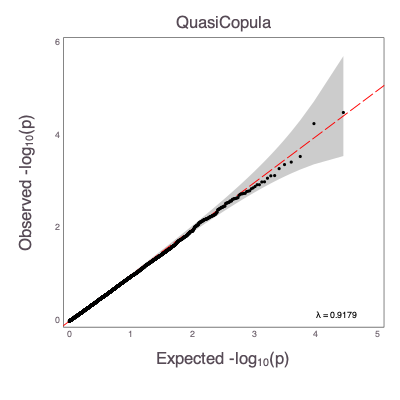

In [14]:
using MendelPlots
idx = findall(!isnan, qc_pvals)
success_pvals = qc_pvals[idx]
idx2 = findall(x -> x < 1e-50, success_pvals)
success_pvals[idx2] .= 1e-50
qq(success_pvals, dpi=80, titles="QuasiCopula")
display("image/png", read("qqplot.png"))

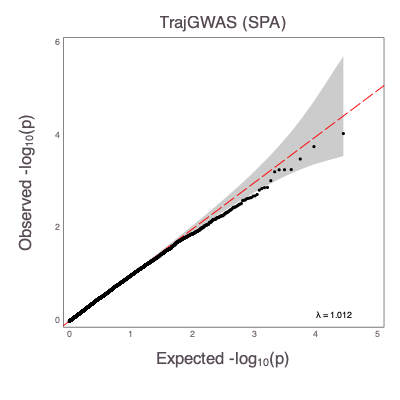

In [15]:
using MendelPlots
idx = findall(!isone, trajGWAS_result[!, "betapval"])
qq(trajGWAS_result[idx, "betapval"], dpi=80, titles="TrajGWAS (SPA)")
display("image/png", read("qqplot.png"))